# Instructions for Running the Notebook

This notebook is a comprehensive implementation of emotion classification using various models (Logistic Regression, Feedforward Neural Networks, and BERT) on a sentiment analysis dataset. Below are detailed instructions to set up and run the notebook effectively.

# Outline of the Notebook

- **Data Preparation:** Cleaning and preprocessing the text data.
- **Exploratory Data Analysis (EDA):** Visualizations and word clouds.
- **Model 1: Logistic Regression**
  - Feature Representation (BoW, TF-IDF)
  - Hyperparameter Tuning (RandomSearchCV)
  - Model Evaluation
- **Model 2: Feedforward Neural Network**
  - Feature Representation (Word2Vec, TF-IDF)
  - Hyperparameter Tuning (Optuna)
  - Model Evaluation
- **Model 3: BERT**
  - Hyperparameter Tuning (Optuna)
  - Model Evaluation

# Package Installations

To run the notebook, ensure the following libraries are installed. Use the commands below to install any missing dependencies:

**`pip install pandas matplotlib seaborn sklearn nltk transformers optuna tensorflow gensim wordcloud tqdm`**

# Google Drive/Local Machine Setup

- If running on Google Colab with Google Drive for dataset storage, run the following lines to mount Google Drive:

  - **`from google.colab import drive`**

  - **`drive.mount('/content/drive')`**

- If running on a local machine, comment out Google Drive mounting lines:

  - **`# from google.colab import drive`**

  - **`# drive.mount('/content/drive')`**

  - Replace any references to /content/drive/MyDrive/... with the relative or absolute paths to your local dataset directory. For example:
  
    - df = prepare_sentiment_data('/content/drive/MyDrive/cs4120_final_project/data')
    - df = prepare_sentiment_data('./data')

# Running the Notebook

1. Ensure the dataset files (data-split.json and emowoz-multiwoz.json) are placed in the correct directory.
2. Run the notebook cell-by-cell or hit Kernel > Restart and Run All.
3. The classification reports and performance metrics for each model will be displayed at the end of each section.


In [1]:
####################################################
#### Mount to Google Drive
####################################################
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:

# Default libraries
import pandas as pd
import json
from pathlib import Path
import re
import string
import time
from collections import Counter
import numpy as np
from typing import List, Dict, Tuple

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# ml
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import classification_report, mean_squared_error, accuracy_score
import gensim
from gensim.models import Word2Vec
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Flatten
!pip install optuna
import optuna
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, BertModel

# miscellaneous
import os
from wordcloud import WordCloud
from tqdm.notebook import tqdm
from multiprocessing import Pool
from multiprocessing import get_context, cpu_count

# nltk
from nltk.tokenize import word_tokenize
import nltk

nltk.download('stopwords')
nltk.download('punkt_tab')
from nltk.corpus import stopwords


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 18.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 20.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 7.8 MB/s eta 0:00:00


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


# Util Functions

In [3]:
def clean_text(text):
    """
    Cleans text by converting to lowercase, removing punctuation, emojis, and special characters.

    Parameters:
    text (str): Input text string.

    Returns:
    str: Cleaned text.
    """
    # Converting to lowercase
    text = text.lower()
    # Removing punctuation, emojis, and special characters
    text = re.sub(r"[^a-zA-Z\s]", "", text)
    return text.strip()

In [4]:
def load_splits(split_path: str) -> Dict[str, List[str]]:
    """
    Loads train/dev/test splits from a JSON file for multiwoz data.

    Parameters:
    split_path (str): Path to the JSON file containing splits.

    Returns:
    dict: Dictionary containing train, dev, and test splits.
    """
    with open(split_path, 'r') as f:
        data = json.load(f)
    return {
        'train': data.get('train', {}).get('multiwoz', []),
        'dev': data.get('dev', {}).get('multiwoz', []),
        'test': data.get('test', {}).get('multiwoz', [])
    }

In [5]:
def process_dialogue_data(file_path: str, dialogue_splits: Dict[str, List[str]]) -> pd.DataFrame:
    """
    Processes multiwoz dialogues, extracting user turns with emotions and assigning splits.

    Parameters:
    file_path (str): Path to the multiwoz dialogue JSON file.
    dialogue_splits (dict): Dictionary containing train/dev/test splits.

    Returns:
    pd.DataFrame: DataFrame with columns:
        - dialogue_id: Unique dialogue identifier.
        - turn_id: Turn number within dialogue.
        - text: User utterance.
        - emotion_label: Resolved emotion (0-6).
        - sentiment_label: Mapped sentiment (0-2).
        - split: Train/Dev/Test split.
    """
    records = []
    with open(file_path, 'r') as f:
        dialogues = json.load(f)

    for dialogue_id, content in dialogues.items():
        # Skipping non-multiwoz dialogues
        if dialogue_id.startswith('DMAGE'):
            continue

        # Getting split for this dialogue
        if dialogue_id in dialogue_splits['train']:
            split = 'train'
        elif dialogue_id in dialogue_splits['dev']:
            split = 'dev'
        elif dialogue_id in dialogue_splits['test']:
            split = 'test'
        else:
            continue

        # Processing turns
        for turn_idx, turn in enumerate(content['log']):
            emotion_data = turn.get('emotion', [])
            # Only processing turns with emotion annotations
            if emotion_data:
                final_annotation = emotion_data[-1]
                records.append({
                    'dialogue_id': dialogue_id,
                    'turn_id': turn_idx,
                    'text': turn['text'],
                    'emotion_label': final_annotation.get('emotion'),
                    'sentiment_label': final_annotation.get('sentiment'),
                    'split': split
                })

    return pd.DataFrame(records)

In [6]:
def prepare_sentiment_data(data_dir: str = 'data/') -> pd.DataFrame:
    """
    Prepares the sentiment analysis dataset by processing dialogues and cleaning text.

    Parameters:
    data_dir (str): Directory containing data files. Defaults to 'data/'.

    Returns:
    pd.DataFrame: Cleaned and processed sentiment analysis dataset.
    """
    # Loading splits
    splits = load_splits(f'{data_dir}/data-split.json')

    # Processing dialogues and adding text tokens
    df = process_dialogue_data(f'{data_dir}/emowoz-multiwoz.json', splits)
    df['text'] = df['text'].apply(clean_text)

    return df

In [7]:
# +
# Defining label mappings
MAPPINGS = {
    'emotion_label': {
        0: "Neutral",
        1: "Fearful, Sad, Disappointed",
        2: "Dissatisfied, Disliking",
        3: "Apologetic",
        4: "Abusive",
        5: "Excited, Happy, Anticipating",
        6: "Satisfied, Liking"
    },
    'sentiment_label': {
        0: "Neutral",
        1: "Negative",
        2: "Positive"
    },
    'split': {
        'train': "Train",
        'dev': "Dev",
        'test': "Test"
    }
}

def analyze_distribution(df, column, mapping=None):
    """
    Analyzes and visualizes the distribution of a specified column in the dataset.

    Parameters:
    df (pd.DataFrame): Dataset to analyze.
    column (str): Column name to analyze (e.g., 'emotion_label', 'sentiment_label').
    mapping (dict, optional): Mapping of values to labels. If None, uses predefined mappings.

    Returns:
    pd.DataFrame: DataFrame containing distribution counts and percentages.
    """
    # Setting up parameters
    mapping = mapping or MAPPINGS.get(column, {})
    title_label = column.replace('_', ' ').title()

    # Getting distribution
    dist = df[column].value_counts().sort_index()

    # Calculating percentages
    total = dist.sum()
    percentages = (dist / total * 100).round(2)

    # Creating DataFrame with labels and percentages
    dist_df = pd.DataFrame({
        'Label': [mapping.get(i, str(i)) for i in dist.index],
        'Count': dist.values,
        'Percentage': percentages.values
    })
    dist_df['Percentage'] = dist_df['Percentage'].astype(str) + '%'

    print(f"Distribution of {title_label} in MultiWOZ:")
    print(dist_df)

    # Creating bar plot
    plt.figure(figsize=(9, 6))
    sns.barplot(data=dist_df, x='Label', y='Count')
    plt.xticks(rotation=45, ha='right')
    plt.title(f'Distribution of {title_label} in MultiWOZ Dataset')
    plt.ylabel('Count')
    plt.tight_layout()
    plt.show()

    return dist_df

In [8]:
def embedding_maps(word_embeddings, tokenizer):
  '''
  Creates a mapping from a word to its vector embedding and from a word index to its vector embedding

  Input:
  - word_embeddings (Word2Vec model object):
  - tokenizer (Tokenizer object):

  Output:
  - word_2_embedding (dict): mapping from a word to its vector embedding
  - index_2_embedding (dict): mapping from a word index to its vector embedding
  '''

  word_2_embedding = {}
  index_2_embedding = {}

  for word in tokenizer.word_index:
    if word in word_embeddings.wv:
      embedding = word_embeddings.wv[word]
    else:
      embedding = np.zeros(42)

    word_2_embedding[word] = embedding
    index_2_embedding[tokenizer.word_index[word]] = embedding

  return word_2_embedding, index_2_embedding

In [9]:
def train_epoch(model, data_loader, optimizer, criterion, device):
    """
    Trains the model for one epoch.

    Parameters:
    model (torch.nn.Module): Model to train.
    data_loader (DataLoader): DataLoader for training data.
    optimizer (torch.optim.Optimizer): Optimizer for the model.
    criterion (torch.nn.Module): Loss function.
    device (torch.device): Device to run the model on.

    Returns:
    tuple: Average loss and accuracy for the epoch.
    """
    model.train()
    total_loss, correct = 0, 0
    for batch in tqdm(data_loader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask)
        loss = criterion(outputs.logits, labels)
        total_loss += loss.item()
        preds = torch.argmax(outputs.logits, dim=1)
        correct += (preds == labels).sum().item()

        loss.backward()
        optimizer.step()

    accuracy = correct / len(data_loader.dataset)
    return total_loss / len(data_loader), accuracy

In [10]:
def eval_model(model, data_loader, criterion, device):
    """
    Evaluates the model on validation or test data.

    Parameters:
    model (torch.nn.Module): Model to evaluate.
    data_loader (DataLoader): DataLoader for evaluation data.
    criterion (torch.nn.Module): Loss function.
    device (torch.device): Device to run the model on.

    Returns:
    tuple: Average loss and accuracy for the evaluation.
    """
    model.eval()
    total_loss, correct = 0, 0
    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            loss = criterion(outputs.logits, labels)
            total_loss += loss.item()
            preds = torch.argmax(outputs.logits, dim=1)
            correct += (preds == labels).sum().item()

    accuracy = correct / len(data_loader.dataset)
    return total_loss / len(data_loader), accuracy


In [11]:
# Dataset preparation function
class SentimentDataset(Dataset):
    """
    Custom PyTorch Dataset for sentiment analysis.

    Parameters:
    texts (pd.Series): Series containing input text data.
    labels (pd.Series): Series containing corresponding labels for the text data.
    tokenizer (transformers.PreTrainedTokenizer): Tokenizer for encoding text.
    max_len (int): Maximum length for tokenized sequences.

    Methods:
    __len__(): Returns the number of samples in the dataset.
    __getitem__(idx): Retrieves a single data sample, including input IDs, attention mask, and label.

    Returns:
    dict: Dictionary containing:
        - 'input_ids': Tensor of tokenized input IDs.
        - 'attention_mask': Tensor indicating attention mask.
        - 'label': Tensor containing the label for the text.
    """
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts.tolist()
        self.labels = labels.tolist()
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        inputs = self.tokenizer(
            text,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_tensors="pt"
        )
        return {
            'input_ids': inputs['input_ids'].squeeze(0),
            'attention_mask': inputs['attention_mask'].squeeze(0),
            'label': torch.tensor(label, dtype=torch.long)
        }

In [12]:
def plot_wordcloud(data, title):
    """
    Generates and displays a word cloud visualization for text data.

    Parameters:
    data (list or iterable): List of text data to visualize.
    title (str): Title for the word cloud plot.

    Returns:
    None: Displays the word cloud plot.
    """
    text = " ".join(data)
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=16)
    plt.show()

# Loading the data

In [13]:
# Loading and preprocessing the data
# STOPWORDS = set(stopwords.words('english'))

df = prepare_sentiment_data('/content/drive/MyDrive/cs4120_final_project/data')
df = df.drop(['dialogue_id', 'sentiment_label', 'turn_id', 'split'], axis=1)
df.head()

,text,emotion_label
0,how are you doing are there any european resta...,0
1,can i get the name and address of one of the m...,0
2,thanks so much i am also looking for places to...,6
3,i would like to see colleges can you please r...,0
4,thank you that was all i needed,6


# Exploratory Data Analysis

Distribution of Emotion Label in MultiWOZ:
                          Label  Count Percentage
0                       Neutral  51426      71.9%
1    Fearful, Sad, Disappointed    381      0.53%
2       Dissatisfied, Disliking    914      1.28%
3                    Apologetic    838      1.17%
4                       Abusive     44      0.06%
5  Excited, Happy, Anticipating    860       1.2%
6             Satisfied, Liking  17061     23.85%


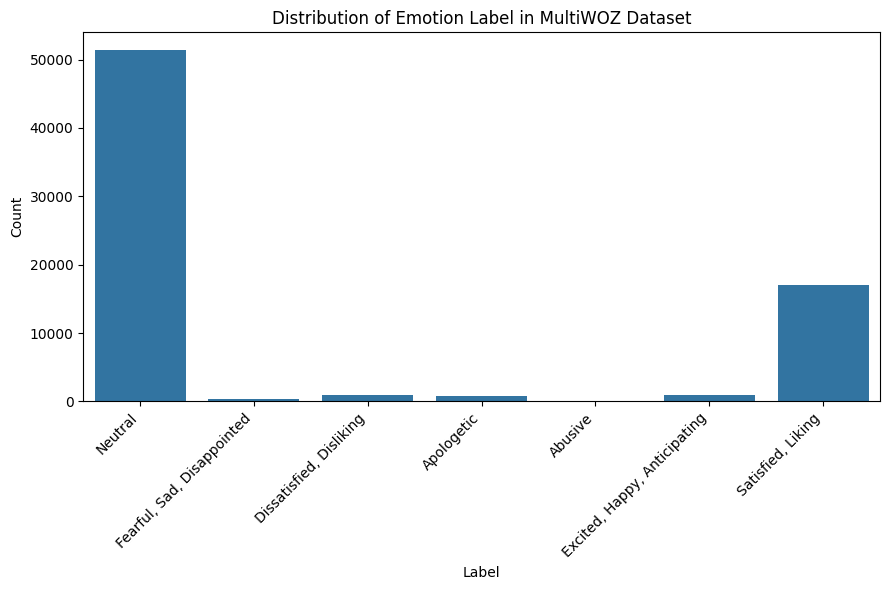

In [14]:
emotion_dist = analyze_distribution(df, 'emotion_label')

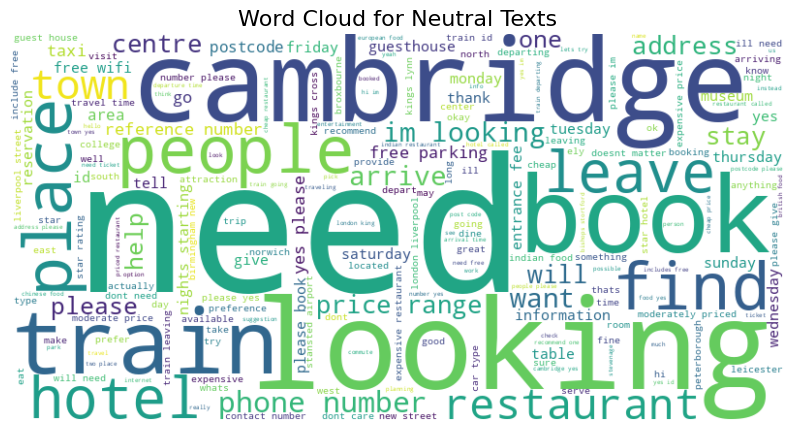

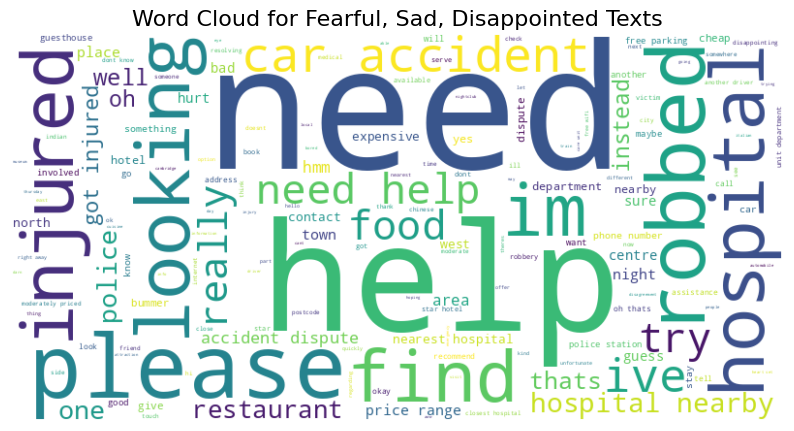

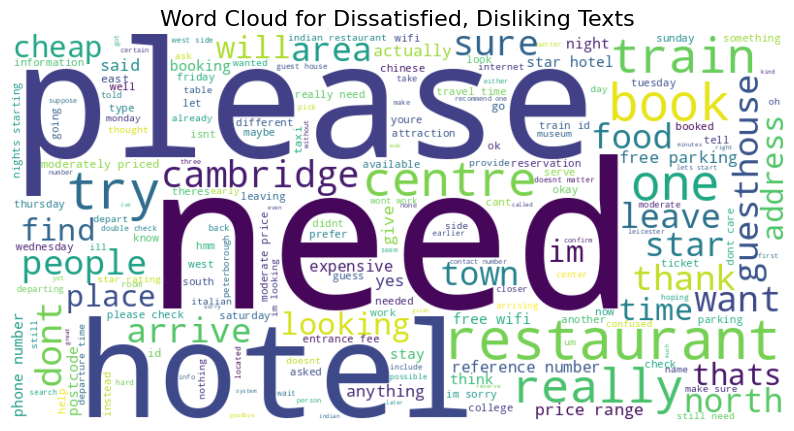

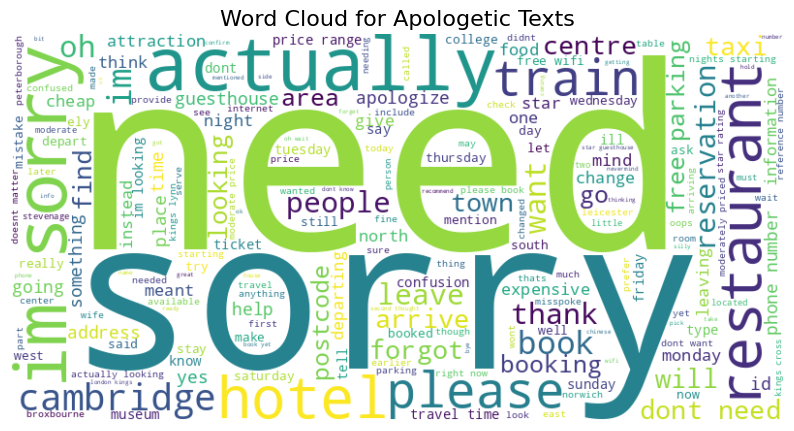

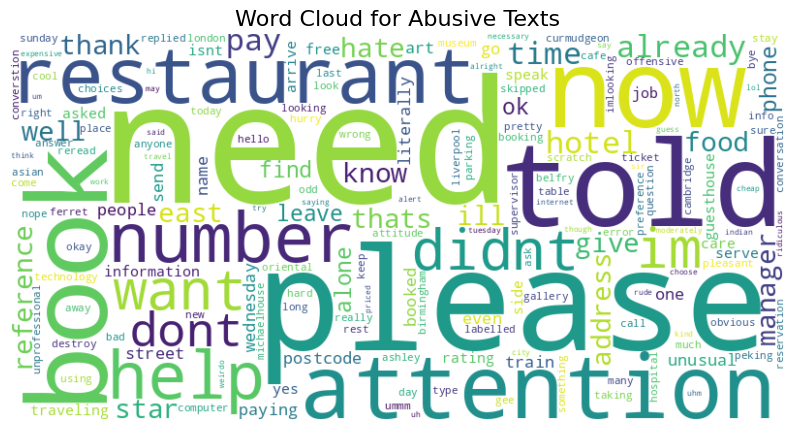

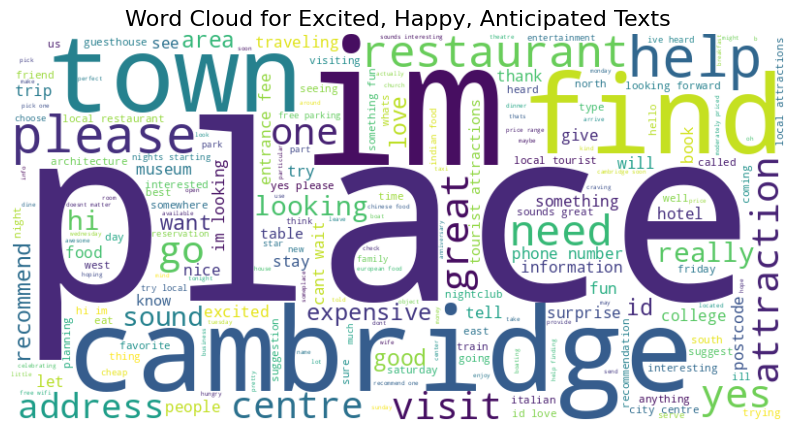

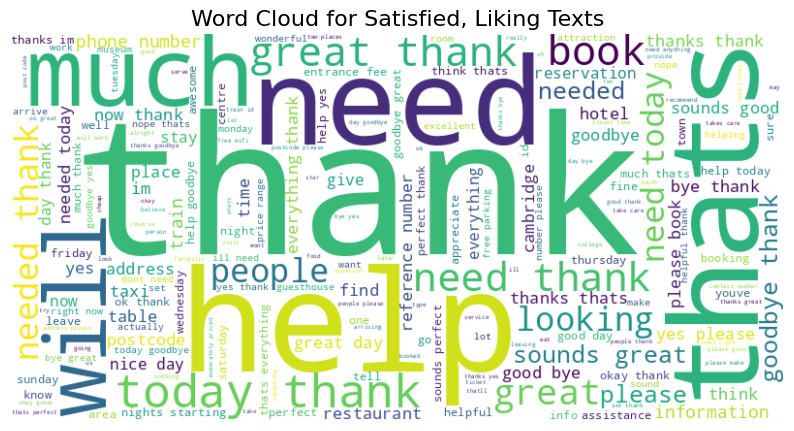

In [15]:
# WordCloud for different emotions:
neutral_text = df[df['emotion_label'] == 0]['text']
sad_text = df[df['emotion_label'] == 1]['text']
dislike_text = df[df['emotion_label'] == 2]['text']
apologetic_text = df[df['emotion_label'] == 3]['text']
abusive_text = df[df['emotion_label'] == 4]['text']
happy_text = df[df['emotion_label'] == 5]['text']
like_text = df[df['emotion_label'] == 6]['text']

plot_wordcloud(neutral_text, "Word Cloud for Neutral Texts")
plot_wordcloud(sad_text, "Word Cloud for Fearful, Sad, Disappointed Texts")
plot_wordcloud(dislike_text, "Word Cloud for Dissatisfied, Disliking Texts")
plot_wordcloud(apologetic_text, "Word Cloud for Apologetic Texts")
plot_wordcloud(abusive_text, "Word Cloud for Abusive Texts")
plot_wordcloud(happy_text, "Word Cloud for Excited, Happy, Anticipated Texts")
plot_wordcloud(like_text, "Word Cloud for Satisfied, Liking Texts")

# Model 1: Logistic Regression

In [16]:
# Splitting X and y variables
X = df['text']
y = df['emotion_label']

# Splitting into train, test, and val (70/15/15)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

## Feature Representation

### BoW

In [17]:
# BoW Feature Representation
bow_vectorizer = CountVectorizer(max_features=5000, stop_words='english')
X_train_bow = bow_vectorizer.fit_transform(X_train)
X_val_bow = bow_vectorizer.transform(X_val)

### TF-IDF

In [18]:
# TF-IDF Feature Representation
tfidf_vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_val_tfidf = tfidf_vectorizer.transform(X_val)

## Hyperparamater Tuning

In [19]:
# Defining ranges for each class weight.
weight_options_class1 = [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0]
weight_options_class2 = [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0]
weight_options_class3 = [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0]
weight_options_class4 = [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0]
weight_options_class5 = [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0]
weight_options_class6 = [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0]

# Generating candidate weight dictionaries.
candidate_weights = []
for w1 in weight_options_class1:
    for w2 in weight_options_class2:
        for w3 in weight_options_class3:
            for w4 in weight_options_class4:
                for w5 in weight_options_class5:
                    for w6 in weight_options_class6:
                        cw = {
                            0: 1.0,
                            1: w1,
                            2: w2,
                            3: w3,
                            4: w4,
                            5: w5,
                            6: w6
                        }
                        candidate_weights.append(cw)

print("Number of candidate class weight combinations:", len(candidate_weights))

# Adding regularization strength and penalty type to parameter distribution
param_dist = {
    'class_weight': candidate_weights,
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
}


Number of candidate class weight combinations: 1000000


### BoW

In [20]:
lr = LogisticRegression(max_iter=1000, solver='liblinear', random_state=42)

# Randomized search by picking 'n_iter' random sets of class weights
random_search = RandomizedSearchCV(
    estimator=lr,
    param_distributions=param_dist,
    n_iter=50,
    scoring='f1_weighted',
    cv=3,
    random_state=42,
    n_jobs=-1,
    verbose=1
)

random_search.fit(X_train_bow, y_train)
print("Best parameters found (BoW):", random_search.best_params_)
print("Best score (BoW):", random_search.best_score_)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best parameters found (BoW): {'penalty': 'l1', 'class_weight': {0: 1.0, 1: 9.0, 2: 8.0, 3: 2.0, 4: 6.0, 5: 4.0, 6: 4.0}, 'C': 1}
Best score (BoW): 0.9103601157473701


### TF-IDF

In [21]:
lr_tfidf = LogisticRegression(max_iter=1000, solver='liblinear', random_state=42)

# Randomized search by picking 'n_iter' random sets of class weights
random_search_tfidf = RandomizedSearchCV(
    estimator=lr_tfidf,
    param_distributions=param_dist,
    n_iter=50,
    scoring='f1_weighted',
    cv=3,
    random_state=42,
    n_jobs=-1,
    verbose=1
)

random_search_tfidf.fit(X_train_tfidf, y_train)
print("\nBest parameters found (TF-IDF):", random_search_tfidf.best_params_)
print("Best score (TF-IDF):", random_search_tfidf.best_score_)

Fitting 3 folds for each of 50 candidates, totalling 150 fits

Best parameters found (TF-IDF): {'penalty': 'l1', 'class_weight': {0: 1.0, 1: 9.0, 2: 8.0, 3: 2.0, 4: 6.0, 5: 4.0, 6: 4.0}, 'C': 1}
Best score (TF-IDF): 0.9060556311132354


## Model Evaluation

### BoW

In [22]:
# Evaluating the best BoW model on the test set
best_model_bow = random_search.best_estimator_
X_test_bow = bow_vectorizer.transform(X_test)
y_test_pred_bow = best_model_bow.predict(X_test_bow)

print("Test Results with Best Class Weight (BoW):")
print(classification_report(y_test, y_test_pred_bow, target_names=MAPPINGS['emotion_label'].values()))

Test Results with Best Class Weight (BoW):
                              precision    recall  f1-score   support

                     Neutral       0.95      0.95      0.95      7671
  Fearful, Sad, Disappointed       0.78      0.47      0.59        59
     Dissatisfied, Disliking       0.29      0.14      0.19       131
                  Apologetic       0.88      0.62      0.73       121
                     Abusive       0.00      0.00      0.00         6
Excited, Happy, Anticipating       0.45      0.28      0.35       125
           Satisfied, Liking       0.86      0.93      0.89      2616

                    accuracy                           0.92     10729
                   macro avg       0.60      0.48      0.53     10729
                weighted avg       0.91      0.92      0.91     10729



### TF-IDF

In [23]:
# Evaluating the best TF-IDF model on the test set
best_model_tfidf = random_search_tfidf.best_estimator_
X_test_tfidf = tfidf_vectorizer.transform(X_test)
y_test_pred_tfidf = best_model_tfidf.predict(X_test_tfidf)

print("\nTest Results with Best Class Weight (TF-IDF):")
print(classification_report(y_test, y_test_pred_tfidf, target_names=MAPPINGS['emotion_label'].values()))



Test Results with Best Class Weight (TF-IDF):
                              precision    recall  f1-score   support

                     Neutral       0.94      0.95      0.94      7671
  Fearful, Sad, Disappointed       0.77      0.46      0.57        59
     Dissatisfied, Disliking       0.29      0.11      0.16       131
                  Apologetic       0.89      0.62      0.73       121
                     Abusive       0.00      0.00      0.00         6
Excited, Happy, Anticipating       0.47      0.27      0.35       125
           Satisfied, Liking       0.88      0.90      0.89      2616

                    accuracy                           0.91     10729
                   macro avg       0.61      0.47      0.52     10729
                weighted avg       0.91      0.91      0.91     10729



# Model 2: Feed Forward Neural Network

In [24]:
# Oversampling all classes to the same size
print("Class distribution BEFORE oversampling:")
print(Counter(df['emotion_label']))

# Finding the maximum class count
max_count = df['emotion_label'].value_counts().max()

# Oversampling each class to match the maximum count
oversampled_dfs = []
for label in df['emotion_label'].unique():
    subset = df[df['emotion_label'] == label]
    oversampled_subset = subset.sample(n=max_count, replace=True, random_state=42)
    oversampled_dfs.append(oversampled_subset)

# Combining the oversampled subsets
df_balanced = pd.concat(oversampled_dfs, ignore_index=True)

print("Class distribution AFTER oversampling:")
print(df_balanced['emotion_label'].value_counts())

Class distribution BEFORE oversampling:
Counter({0: 51426, 6: 17061, 2: 914, 5: 860, 3: 838, 1: 381, 4: 44})
Class distribution AFTER oversampling:
emotion_label
0    51426
6    51426
2    51426
5    51426
3    51426
1    51426
4    51426
Name: count, dtype: int64


In [25]:
# Splitting the data
X = df_balanced['text']
y = df_balanced['emotion_label']

# Splitting into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Training size: {len(X_train)}, Validation size: {len(X_val)}, Test size: {len(X_test)}")

Training size: 251987, Validation size: 53997, Test size: 53998


## Feature Representation

### Word2Vec

In [26]:
# Featurization with Word2Vec
# Tokenizing the text
X_train_tokens = X_train.apply(word_tokenize)
X_val_tokens = X_val.apply(word_tokenize)
X_test_tokens = X_test.apply(word_tokenize)

# Training Word2Vec embeddings on the training data
word_embeddings = Word2Vec(sentences=X_train_tokens, vector_size=42, window=5, min_count=1, sg=1)

# Creating embedding maps
word_tokenizer = Tokenizer(char_level=False)
word_tokenizer.fit_on_texts(X_train_tokens)
encoded_words = word_tokenizer.texts_to_sequences(X_train_tokens)

word_2_embedding, index_2_embedding = embedding_maps(word_embeddings, word_tokenizer)
# Adding padding token embedding
index_2_embedding[0] = np.zeros(42)

# Padding sequences for fixed input size
X_train_w2v = pad_sequences(encoded_words, maxlen=42, padding='post')

# Repeating for validation and test
X_val_encoded = word_tokenizer.texts_to_sequences(X_val_tokens)
X_val_w2v = pad_sequences(X_val_encoded, maxlen=42, padding='post')

X_test_encoded = word_tokenizer.texts_to_sequences(X_test_tokens)
X_test_w2v = pad_sequences(X_test_encoded, maxlen=42, padding='post')


### TF-IDF

In [27]:
# Featurization with TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')

# Fitting on training data and transforming all sets
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train).toarray()
X_val_tfidf = tfidf_vectorizer.transform(X_val).toarray()
X_test_tfidf = tfidf_vectorizer.transform(X_test).toarray()


## Hyperparameter Tuning

### Word2Vec

In [28]:
# Hyperparameter Tuning for Word2Vec
def objective_w2v(trial):
    # Hyperparameters
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-2, log=True)
    units_input = trial.suggest_categorical("units_input", [256, 512])
    units_hidden = trial.suggest_categorical("units_hidden", [128, 256])
    dropout_rate = trial.suggest_float("dropout_rate", 0.3, 0.7)
    batch_size = trial.suggest_categorical("batch_size", [32, 64])
    epochs = 5  # Fixed for simplicity

    # Model definition
    model = Sequential()
    model.add(Dense(units=units_input, input_shape=(42,), activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    model.add(Dense(units=units_hidden, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    model.add(Dense(units=7, activation='softmax'))

    # Compiling the model
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # Training the model
    model.fit(X_train_w2v, y_train, batch_size=batch_size, epochs=epochs, verbose=0, validation_data=(X_val_w2v, y_val))

    # Evaluating on validation set
    y_val_pred = model.predict(X_val_w2v)
    y_val_pred_classes = np.argmax(y_val_pred, axis=1)

    return accuracy_score(y_val, y_val_pred_classes)

# Running Optuna study
study_w2v = optuna.create_study(direction="maximize")
study_w2v.optimize(objective_w2v, n_trials=10)

# Best hyperparameters
best_params_w2v = study_w2v.best_params
print(f"Best Hyperparameters (Word2Vec): {best_params_w2v}")

[I 2024-12-11 20:02:37,706] A new study created in memory with name: no-name-1d420a77-d7ee-4116-9768-6374dff4d572
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1688/1688 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step


[I 2024-12-11 20:03:24,602] Trial 0 finished with value: 0.575920884493583 and parameters: {'learning_rate': 0.0007700013411652076, 'units_input': 256, 'units_hidden': 128, 'dropout_rate': 0.572580788836728, 'batch_size': 64}. Best is trial 0 with value: 0.575920884493583.
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1688/1688 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


[I 2024-12-11 20:04:42,600] Trial 1 finished with value: 0.6021816026816305 and parameters: {'learning_rate': 0.008614553353298516, 'units_input': 256, 'units_hidden': 128, 'dropout_rate': 0.3700071071346716, 'batch_size': 32}. Best is trial 1 with value: 0.6021816026816305.
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1688/1688 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


[I 2024-12-11 20:05:25,958] Trial 2 finished with value: 0.5618460284830639 and parameters: {'learning_rate': 0.000824786511337322, 'units_input': 256, 'units_hidden': 256, 'dropout_rate': 0.6212373282138242, 'batch_size': 64}. Best is trial 1 with value: 0.6021816026816305.
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1688/1688 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


[I 2024-12-11 20:06:43,942] Trial 3 finished with value: 0.5114728596033113 and parameters: {'learning_rate': 8.706783176021144e-05, 'units_input': 256, 'units_hidden': 128, 'dropout_rate': 0.45652906912264646, 'batch_size': 32}. Best is trial 1 with value: 0.6021816026816305.
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1688/1688 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


[I 2024-12-11 20:08:01,471] Trial 4 finished with value: 0.5873659647758209 and parameters: {'learning_rate': 0.005683572633925443, 'units_input': 256, 'units_hidden': 128, 'dropout_rate': 0.4794875211656414, 'batch_size': 32}. Best is trial 1 with value: 0.6021816026816305.
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1688/1688 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step


[I 2024-12-11 20:08:46,995] Trial 5 finished with value: 0.7141507861547863 and parameters: {'learning_rate': 0.002259601120436764, 'units_input': 512, 'units_hidden': 256, 'dropout_rate': 0.4648188035261294, 'batch_size': 64}. Best is trial 5 with value: 0.7141507861547863.
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1688/1688 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


[I 2024-12-11 20:10:06,002] Trial 6 finished with value: 0.7256884641739356 and parameters: {'learning_rate': 0.0008403999464265743, 'units_input': 512, 'units_hidden': 128, 'dropout_rate': 0.30552502274447985, 'batch_size': 32}. Best is trial 6 with value: 0.7256884641739356.
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1688/1688 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


[I 2024-12-11 20:11:24,891] Trial 7 finished with value: 0.693131099875919 and parameters: {'learning_rate': 0.000857075638302861, 'units_input': 256, 'units_hidden': 256, 'dropout_rate': 0.3630606070099473, 'batch_size': 32}. Best is trial 6 with value: 0.7256884641739356.
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1688/1688 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


[I 2024-12-11 20:12:45,204] Trial 8 finished with value: 0.6249606459618127 and parameters: {'learning_rate': 0.0011536989828638316, 'units_input': 512, 'units_hidden': 256, 'dropout_rate': 0.5934538976807037, 'batch_size': 32}. Best is trial 6 with value: 0.7256884641739356.
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1688/1688 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


[I 2024-12-11 20:14:01,915] Trial 9 finished with value: 0.6242569031612868 and parameters: {'learning_rate': 0.0028163708539190833, 'units_input': 256, 'units_hidden': 256, 'dropout_rate': 0.4570792352970292, 'batch_size': 32}. Best is trial 6 with value: 0.7256884641739356.


Best Hyperparameters (Word2Vec): {'learning_rate': 0.0008403999464265743, 'units_input': 512, 'units_hidden': 128, 'dropout_rate': 0.30552502274447985, 'batch_size': 32}


### TF-IDF

In [29]:
# Hyperparameter Tuning for TF-IDF
def objective_tfidf(trial):
    # Hyperparameters
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-2, log=True)
    units_input = trial.suggest_categorical("units_input", [256, 512])
    units_hidden = trial.suggest_categorical("units_hidden", [128, 256])
    dropout_rate = trial.suggest_float("dropout_rate", 0.3, 0.7)
    batch_size = trial.suggest_categorical("batch_size", [32, 64])
    epochs = 5  # Fixed for simplicity

    # Model definition
    model = Sequential()
    model.add(Dense(units=units_input, input_dim=X_train_tfidf.shape[1], activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    model.add(Dense(units=units_hidden, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    model.add(Dense(units=7, activation='softmax'))

    # Compiling the model
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # Training the model
    model.fit(X_train_tfidf, y_train, batch_size=batch_size, epochs=epochs, verbose=0, validation_data=(X_val_tfidf, y_val))

    # Evaluating on validation set
    y_val_pred = model.predict(X_val_tfidf)
    y_val_pred_classes = np.argmax(y_val_pred, axis=1)

    return accuracy_score(y_val, y_val_pred_classes)

# Running Optuna study
study_tfidf = optuna.create_study(direction="maximize")
study_tfidf.optimize(objective_tfidf, n_trials=10)

# Best hyperparameters
best_params_tfidf = study_tfidf.best_params
print(f"Best Hyperparameters (TF-IDF): {best_params_tfidf}")


[I 2024-12-11 20:15:01,345] A new study created in memory with name: no-name-d1d64247-da44-4b66-bc15-00f78d42116f
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1688/1688 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step


[I 2024-12-11 20:16:43,105] Trial 0 finished with value: 0.971090986536289 and parameters: {'learning_rate': 0.007520846238425218, 'units_input': 256, 'units_hidden': 128, 'dropout_rate': 0.46450968600947085, 'batch_size': 32}. Best is trial 0 with value: 0.971090986536289.
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1688/1688 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


[I 2024-12-11 20:18:22,870] Trial 1 finished with value: 0.9379224771746578 and parameters: {'learning_rate': 2.983634734472532e-05, 'units_input': 256, 'units_hidden': 128, 'dropout_rate': 0.6375927318020326, 'batch_size': 32}. Best is trial 0 with value: 0.971090986536289.
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1688/1688 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step


[I 2024-12-11 20:19:31,364] Trial 2 finished with value: 0.9742022704965091 and parameters: {'learning_rate': 0.006644578514184361, 'units_input': 512, 'units_hidden': 128, 'dropout_rate': 0.4846102589112763, 'batch_size': 64}. Best is trial 2 with value: 0.9742022704965091.
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1688/1688 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


[I 2024-12-11 20:21:20,115] Trial 3 finished with value: 0.9757764320240013 and parameters: {'learning_rate': 0.0017106236561410676, 'units_input': 512, 'units_hidden': 128, 'dropout_rate': 0.4021601078077357, 'batch_size': 32}. Best is trial 3 with value: 0.9757764320240013.
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1688/1688 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


[I 2024-12-11 20:22:24,443] Trial 4 finished with value: 0.967053725206956 and parameters: {'learning_rate': 9.902836193149984e-05, 'units_input': 256, 'units_hidden': 128, 'dropout_rate': 0.6200238342717859, 'batch_size': 64}. Best is trial 3 with value: 0.9757764320240013.
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1688/1688 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step


[I 2024-12-11 20:23:27,349] Trial 5 finished with value: 0.9693501490823564 and parameters: {'learning_rate': 7.690657387250773e-05, 'units_input': 256, 'units_hidden': 256, 'dropout_rate': 0.5326697606916743, 'batch_size': 64}. Best is trial 3 with value: 0.9757764320240013.
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1688/1688 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


[I 2024-12-11 20:24:30,527] Trial 6 finished with value: 0.9665166583328704 and parameters: {'learning_rate': 0.0036977680959847103, 'units_input': 256, 'units_hidden': 128, 'dropout_rate': 0.6914790991660323, 'batch_size': 64}. Best is trial 3 with value: 0.9757764320240013.
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1688/1688 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


[I 2024-12-11 20:26:13,579] Trial 7 finished with value: 0.9696649813878548 and parameters: {'learning_rate': 0.0061587854807708875, 'units_input': 256, 'units_hidden': 128, 'dropout_rate': 0.5674818134732059, 'batch_size': 32}. Best is trial 3 with value: 0.9757764320240013.
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1688/1688 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


[I 2024-12-11 20:28:03,476] Trial 8 finished with value: 0.9635720502990907 and parameters: {'learning_rate': 2.634918308911018e-05, 'units_input': 512, 'units_hidden': 128, 'dropout_rate': 0.5175950112679247, 'batch_size': 32}. Best is trial 3 with value: 0.9757764320240013.
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1688/1688 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step


[I 2024-12-11 20:29:08,422] Trial 9 finished with value: 0.9753875215289738 and parameters: {'learning_rate': 0.0004748780471586192, 'units_input': 256, 'units_hidden': 256, 'dropout_rate': 0.49263396220509115, 'batch_size': 64}. Best is trial 3 with value: 0.9757764320240013.


Best Hyperparameters (TF-IDF): {'learning_rate': 0.0017106236561410676, 'units_input': 512, 'units_hidden': 128, 'dropout_rate': 0.4021601078077357, 'batch_size': 32}


## Model Evaluation

### Word2Vec

In [30]:
# Training and Evaluating Final Model with Word2Vec
model_w2v = Sequential()
model_w2v.add(Dense(units=best_params_w2v['units_input'], activation='relu'))
model_w2v.add(BatchNormalization())
model_w2v.add(Dropout(best_params_w2v['dropout_rate']))
model_w2v.add(Dense(units=best_params_w2v['units_hidden'], activation='relu'))
model_w2v.add(BatchNormalization())
model_w2v.add(Dropout(best_params_w2v['dropout_rate']))
model_w2v.add(Dense(units=7, activation='softmax'))

optimizer = Adam(learning_rate=best_params_w2v['learning_rate'])
model_w2v.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model_w2v.fit(X_train_w2v, y_train, batch_size=best_params_w2v['batch_size'], epochs=10, validation_data=(X_val_w2v, y_val))

# Evaluating on test set
y_test_pred_w2v = model_w2v.predict(X_test_w2v)
y_test_pred_classes_w2v = np.argmax(y_test_pred_w2v, axis=1)

print("\nClassification Report (Word2Vec):")
print(classification_report(y_test, y_test_pred_classes_w2v, target_names=MAPPINGS['emotion_label'].values()))

Epoch 1/10
7875/7875 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - accuracy: 0.4001 - loss: 1.5942 - val_accuracy: 0.5903 - val_loss: 1.1543
Epoch 2/10
7875/7875 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - accuracy: 0.5486 - loss: 1.1817 - val_accuracy: 0.6626 - val_loss: 1.0267
Epoch 3/10
7875/7875 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - accuracy: 0.5902 - loss: 1.0828 - val_accuracy: 0.6887 - val_loss: 0.9717
Epoch 4/10
7875/7875 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - accuracy: 0.6140 - loss: 1.0231 - val_accuracy: 0.7103 - val_loss: 0.9406
Epoch 5/10
7875/7875 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - accuracy: 0.6286 - loss: 0.9915 - val_accuracy: 0.7220 - val_loss: 0.8938
Epoch 6/10
7875/7875 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - accuracy: 0.6382 - loss: 0.9608 - val_accuracy: 0.7291 - val_loss: 0.8896
Epoch 7/10
7875/7875 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - accuracy: 0.6490 - loss: 0.9333 - val_accuracy: 0.7284 - val_loss: 0.8769
Epoch 8/10
7875/7875 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - accuracy: 0.6549 - loss: 0

### TF-IDF

In [31]:
# Training and Evaluating Final Model with TF-IDF
model_tfidf = Sequential()
model_tfidf.add(Dense(units=best_params_tfidf['units_input'], input_dim=X_train_tfidf.shape[1], activation='relu'))
model_tfidf.add(BatchNormalization())
model_tfidf.add(Dropout(best_params_tfidf['dropout_rate']))
model_tfidf.add(Dense(units=best_params_tfidf['units_hidden'], activation='relu'))
model_tfidf.add(BatchNormalization())
model_tfidf.add(Dropout(best_params_tfidf['dropout_rate']))
model_tfidf.add(Dense(units=7, activation='softmax'))

optimizer = Adam(learning_rate=best_params_tfidf['learning_rate'])
model_tfidf.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model_tfidf.fit(X_train_tfidf, y_train, batch_size=best_params_tfidf['batch_size'], epochs=10, validation_data=(X_val_tfidf, y_val))

# Evaluating on test set
y_test_pred_tfidf = model_tfidf.predict(X_test_tfidf)
y_test_pred_classes_tfidf = np.argmax(y_test_pred_tfidf, axis=1)

print("\nClassification Report (TF-IDF):")
print(classification_report(y_test, y_test_pred_classes_tfidf, target_names=MAPPINGS['emotion_label'].values()))


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
7875/7875 ━━━━━━━━━━━━━━━━━━━━ 27s 3ms/step - accuracy: 0.8541 - loss: 0.4291 - val_accuracy: 0.9639 - val_loss: 0.1080
Epoch 2/10
7875/7875 ━━━━━━━━━━━━━━━━━━━━ 18s 2ms/step - accuracy: 0.9523 - loss: 0.1410 - val_accuracy: 0.9709 - val_loss: 0.0826
Epoch 3/10
7875/7875 ━━━━━━━━━━━━━━━━━━━━ 18s 2ms/step - accuracy: 0.9618 - loss: 0.1105 - val_accuracy: 0.9734 - val_loss: 0.0745
Epoch 4/10
7875/7875 ━━━━━━━━━━━━━━━━━━━━ 18s 2ms/step - accuracy: 0.9657 - loss: 0.1002 - val_accuracy: 0.9741 - val_loss: 0.0738
Epoch 5/10
7875/7875 ━━━━━━━━━━━━━━━━━━━━ 18s 2ms/step - accuracy: 0.9695 - loss: 0.0888 - val_accuracy: 0.9759 - val_loss: 0.0678
Epoch 6/10
7875/7875 ━━━━━━━━━━━━━━━━━━━━ 18s 2ms/step - accuracy: 0.9699 - loss: 0.0846 - val_accuracy: 0.9753 - val_loss: 0.0701
Epoch 7/10
7875/7875 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - accuracy: 0.9727 - loss: 0.0788 - val_accuracy: 0.9765 - val_loss: 0.0658
Epoch 8/10
7875/7875 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - accuracy: 0.9729 - loss: 0

# Model 3: BERT

In [32]:
# Automatically use GPU if available, otherwise fall back to CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [33]:
# Splitting X and y variables
X = df['text']
y = df['emotion_label']

# Splitting into train, test, and val (70/15/15)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


In [34]:
# Using pre trained tokenizer
max_len = 128
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')


# Creating datasets
train_dataset = SentimentDataset(X_train, y_train, tokenizer, max_len)
val_dataset = SentimentDataset(X_val, y_val, tokenizer, max_len)
test_dataset = SentimentDataset(X_test, y_test, tokenizer, max_len)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [35]:
def objective(trial):
    # Hyperparameters
    learning_rate = trial.suggest_float("learning_rate", 1e-6, 1e-4, log=True)
    batch_size = trial.suggest_categorical("batch_size", [16, 32])

    # DataLoaders with tuned batch size
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # Model definition
    model = BertForSequenceClassification.from_pretrained(
        'bert-base-uncased',
        num_labels=7
    ).to(device)

    optimizer = AdamW(model.parameters(), lr=learning_rate)
    criterion = torch.nn.CrossEntropyLoss()

    # Training for 1 epoch only for tuning (computational limitations)
    train_epoch(model, train_loader, optimizer, criterion, device)

    # Evaluating on validation set
    val_loss, val_acc = eval_model(model, val_loader, criterion, device)
    return val_acc

In [36]:
# Running Optuna Study
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=5)

# Best hyperparameters
best_params = study.best_params
print(f"Best Hyperparameters: {best_params}")

# Final Model Training and Evaluation
batch_size = best_params['batch_size']
learning_rate = best_params['learning_rate']
epochs = 3  # Fixed for final training

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=7
).to(device)

optimizer = AdamW(model.parameters(), lr=learning_rate)
criterion = torch.nn.CrossEntropyLoss()

[I 2024-12-11 20:39:41,009] A new study created in memory with name: no-name-05a6db5a-1191-45bc-aff9-33c838f02231


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/3130 [00:00<?, ?it/s]

[I 2024-12-11 20:57:09,049] Trial 0 finished with value: 0.9283251001957312 and parameters: {'learning_rate': 3.0844411918090567e-06, 'batch_size': 16}. Best is trial 0 with value: 0.9283251001957312.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/3130 [00:00<?, ?it/s]

[I 2024-12-11 21:14:32,656] Trial 1 finished with value: 0.9322397241122192 and parameters: {'learning_rate': 1.4927670795510182e-05, 'batch_size': 16}. Best is trial 1 with value: 0.9322397241122192.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/3130 [00:00<?, ?it/s]

[I 2024-12-11 21:31:56,065] Trial 2 finished with value: 0.9280454842016963 and parameters: {'learning_rate': 1.6565460380551425e-05, 'batch_size': 16}. Best is trial 1 with value: 0.9322397241122192.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/3130 [00:00<?, ?it/s]

[I 2024-12-11 21:49:19,126] Trial 3 finished with value: 0.9274862522136266 and parameters: {'learning_rate': 6.916950759722634e-05, 'batch_size': 16}. Best is trial 1 with value: 0.9322397241122192.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/1565 [00:00<?, ?it/s]

[I 2024-12-11 22:05:30,751] Trial 4 finished with value: 0.9245968869419331 and parameters: {'learning_rate': 3.921509401324843e-06, 'batch_size': 32}. Best is trial 1 with value: 0.9322397241122192.


Best Hyperparameters: {'learning_rate': 1.4927670795510182e-05, 'batch_size': 16}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [37]:
# Training Loop
for epoch in range(epochs):
    train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion, device)
    val_loss, val_acc = eval_model(model, val_loader, criterion, device)
    print(f"Epoch {epoch+1}: Train Loss={train_loss:.4f}, Train Acc={train_acc:.4f}, Val Loss={val_loss:.4f}, Val Acc={val_acc:.4f}")

# Test Set Evaluation
test_loss, test_acc = eval_model(model, test_loader, criterion, device)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

  0%|          | 0/3130 [00:00<?, ?it/s]

Epoch 1: Train Loss=0.2994, Train Acc=0.9179, Val Loss=0.2406, Val Acc=0.9280


  0%|          | 0/3130 [00:00<?, ?it/s]

Epoch 2: Train Loss=0.2091, Train Acc=0.9334, Val Loss=0.2230, Val Acc=0.9301


  0%|          | 0/3130 [00:00<?, ?it/s]

Epoch 3: Train Loss=0.1763, Train Acc=0.9420, Val Loss=0.2294, Val Acc=0.9310
Test Loss: 0.2198, Test Accuracy: 0.9333


In [38]:
# Classification Report
y_test_pred_logits = []
y_test_labels = []
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask)
        y_test_pred_logits.extend(outputs.logits.cpu().numpy())
        y_test_labels.extend(batch['label'].cpu().numpy())

y_test_pred = np.argmax(y_test_pred_logits, axis=1)

print("\nClassification Report (BERT):")
print(classification_report(y_test_labels, y_test_pred, digits=4))


Classification Report (BERT):
              precision    recall  f1-score   support

           0     0.9497    0.9652    0.9574      7671
           1     0.8205    0.5424    0.6531        59
           2     0.6296    0.2595    0.3676       131
           3     0.8091    0.7355    0.7706       121
           4     0.0000    0.0000    0.0000         6
           5     0.5862    0.2720    0.3716       125
           6     0.9057    0.9251    0.9153      2616

    accuracy                         0.9333     10729
   macro avg     0.6715    0.5285    0.5765     10729
weighted avg     0.9280    0.9333    0.9288     10729



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
